# Создадим двух уровневую модель

- выбираем набор по каунтам + популярные 100 кандидатов айтемов
- добавляем w2v ембединги в качестве фичей 2 уровня
- ранжируем их через классификацию

In [1]:
import os
import csv
import json
import random
import pickle
import glob
from datetime import datetime
from collections import defaultdict

import gensim
import numpy as np
import pandas as pd
import implicit
import lightgbm as lgb
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix
from tqdm import tqdm

from utils import (
    filter_user_item_pairs,
    get_user_item_matrix,
    normalized_average_precision,
    blend_product_lists
)

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

## Формируем выборку для обучения и валидации модели второго уровня


In [2]:
baseline_popular = [
    '4009f09b04', '15ccaa8685', 'f4599ca21a', 'bf07df54e1',
    '4dcf79043e', '4a29330c8d', '3e038662c0', '5cb93c9bc5',
    '439498bce2', '113e3ace79', '0a46068efc', '343e841aaa',
    'dc2001d036', 'f098ee2a85', '5645789fdf', '31dcf71bbd',
    '4c07cb5835', '080ace8748', 'cbe1cd3bb3', 'ea27d5dc75',
    'f95785964a', '6d0f84a0ac', '1c257c1a1b', 'de25bccdaf',
    'f5e18af323', 'ac81544ebc', '5186e12ff4', 'd860464ae1',
    'f43c12d228', 'e6f8ac5174', 'ad865591c6', 'fc5b0d84e8',
    '9b8d3ecb9c', 'c5e3528190', 'f7724d5786', 'a02d521260',
    '298c1acea3', '8d4f7352d7', '4bd01c5234', 'c85e209e7d',
    '0cbc352942', '76ae00433f', '19ae13ddb0', '341735fe50',
    'b43b19cea8', 'ee17733c1a', '86ffd3a584', 'f587bd2528',
    '8f45a9ec73', '719b704cb6', '262509c05d', '70b7a4e9da',
    '88ac98dea5', '647c87e132', '7c39f1d12c', 'd16a7d2bfc',
    '53fc95e177', 'ca824a9b85', 'ed53a4b7bd', '4d3ab3e72c',
    'ccc2662707', '70d4730470', '3a8eeabcab', '9bc0a4e880',
    '796a39257e', 'e46ee264c8', '5ae28e9988', 'e6a5597d19',
    '5c6de3010f', 'f796614aa2', '1972471841', '1da9db7b6f',
    '0e571ffd73', '29d129468a', '72d4fc4afc', 'c55841ae0c',
    '67e5809518', '0f0c1288d3', '1afbeef007', 'e5fc5981e1',
    '17037290be', '79c5b6562f', '13302b5c6a', 'f1605ca1a1',
    'd01f7d44f9', '0446066c06', '7cb8fa065e', '64b86792ca',
    '66eeca18ac', '539b85fe8f', 'a5d2722186', '85a4571042',
    'dc16d77029', '8b89c855dd', 'e5a7ffef11', '851e5a9155',
    'bad210fab0', '7765dc5a61', 'e146513306', '9eed1f0767']
print(len(baseline_popular))

check_clients = [
    '001e840150', '00078c508d', '0008b2cb41', '00035a21d9', '0015aa77ce',
    '00184e8b0a', '000f3b9860', '001c2b565f', '000b0559be', '0016b0d9ad',
    '000a400848', '000940f00a', '000d599743', '00211fcfaa', '002283ef29',
    '001b8d6788', '00071890c8', '0007b4ca21', '000ddb6229', '0006b9ad75',
    '00042a927a', '00213be6fb', '0012d1d4aa', '00209f873d', '00184aab1b',
    '000702109b', '00031cbbe6', '001175d51b', '000bc820f6', '001c8984f0',
    '0010f1f8ca', '0009e6bafa', '000c049a1a', '0007667c60', '000ca87889',
    '00020e7b18', '001fb70769', '001566f916', '00010925a5', '001de90d21',
    '000efde438', '001392b297', '00134e091b', '0001f552b0', '00167a61e2',
    '000df9078a', '0018d2efac', '00047b3720', '00083b5b14', '0021e07838',
    '000c216adb', '001a2412c6', '0004315e57', '0019a16b6b', '000990be82',
    '0019fb86cb', '00184f3b10', '0010082ab3', '001dac232d', '0019ca361b',
    '0017fdd057', '000b9905d8', '0006fca4bf', '00140e5d34', '001d642f66',
    '001cef2991', '000bf8ff33', '00127b29bb', '0019e0f07d', '001c25b9e3',
    '000a9d12ff', '001f46aa2c', '000b45b7ac', '0018650c30', '0008244fb3',
    '0002ce2217', '00174b3561', '0004254599', '00068fd5dc', '001162084a',
    '000220a0a7', '000a00419c', '000bd5f2f1', '000012768d', '00022fd34f',
    '0018dea0ba', '0004e1e14e', '001d004e5e', '0004231e2a', '000bc94494',
    '00184df0c9', '000036f903', '0006f24465', '000ac12729', '0013c0cbab',
    '00177cee3e', '0020f90a83', '00065f11c7', '000f46bbfc', '00038f9200',
    '0017a7ebcb']
print(len(check_clients))

100
101


In [3]:
with open('../_model_files/item_index_02_01_3.pckl', 'rb') as f:
    item_index = pickle.load(f)
index_item = {v: k for k, v in item_index.items()}

with open('../_model_files/model_implicit_nn_tfidf_02_01_3.pckl', 'rb') as f:
    model_nn = pickle.load(f)
    
with open('../_model_files/incremental_encoder_dict_01_23_01.pckl', 'rb') as f:
    inc_encoder = pickle.load(f)

with open('../_model_files/product_features_01_23_01.pckl', 'rb') as f:
    product_features = pickle.load(f)
    
with open('../_model_files/clients_features_01_23_01.pckl', 'rb') as f:
    clients_features = pickle.load(f)

In [4]:
#prodcut_index = inc_encoder.get_column_indexers()['product_id']
#level1_index = inc_encoder.get_column_indexers()['level_1']
#level2_index = inc_encoder.get_column_indexers()['level_2']
#level3_index = inc_encoder.get_column_indexers()['level_3']
#level4_index = inc_encoder.get_column_indexers()['level_4']
#brand_index = inc_encoder.get_column_indexers()['brand_id']
#vendor_index = inc_encoder.get_column_indexers()['vendor_id']

prodcut_index = inc_encoder['product_id']
level1_index = inc_encoder['level_1']
level2_index = inc_encoder['level_2']
level3_index = inc_encoder['level_3']
level4_index = inc_encoder['level_4']
brand_index = inc_encoder['brand_id']
vendor_index = inc_encoder['vendor_id']


def get_user_vector(user_products_, item_index_, user_vector_):
    user_vector = user_vector_.copy()
    
    for pr in user_products_:
        if pr in item_index_:
            user_vector[0, item_index_[pr]] = user_products_[pr]
            
    return user_vector


def get_trans_dates_features(tr_dates, target_dt_):    
    trans_days_diff = [(t - s).days for s, t in zip(tr_dates, tr_dates[1:])]
    
    first_last_days_diff = (tr_dates[-1] - tr_dates[0]).days
    trans_days_diff_avg = round(np.mean(trans_days_diff), 2)
    #trans_days_diff_std = round(np.std(trans_days_diff), 2)
    
    last_tr_days_diff = (target_dt_ - tr_dates[-1]).days
    last_tr_days_ratio = round(last_tr_days_diff/trans_days_diff_avg, 6) if trans_days_diff_avg > 0 else 0
    
    return first_last_days_diff, trans_days_diff_avg, \
        last_tr_days_diff, last_tr_days_ratio


def get_prod_dates_features(pr_dates_, target_dt_):  
    pr_days_diff = [(t - s).days for s, t in zip(pr_dates_, pr_dates_[1:])]   
    
    first_last_pr_days_diff = (pr_dates_[-1] - pr_dates_[0]).days
    pr_days_diff_avg = round(np.mean(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0
    pr_days_diff_std = round(np.std(pr_days_diff), 2) if len(pr_days_diff) > 0 else 0
                        
    last_pr_days_diff = (target_dt_ - pr_dates_[-1]).days
    last_pr_days_ratio = round(last_pr_days_diff/pr_days_diff_avg, 6) if pr_days_diff_avg > 0 else 0
                
    
    return first_last_pr_days_diff, pr_days_diff_avg, pr_days_diff_std, \
        last_pr_days_diff, last_pr_days_ratio

In [5]:
%%time
random.seed(7)
NUM_CANDIDATES_1LEVEL = 100
valid_time = datetime.strptime('2019-03-01 00:00:00', '%Y-%m-%d %H:%M:%S')
valid_chunks = [
    '../_processed_data/client_tr_history_4.tsv', 
    '../_processed_data/client_tr_history_0.tsv',
    '../_processed_data/client_tr_history_15.tsv', 
    '../_processed_data/client_tr_history_16.tsv', 
    '../_processed_data/client_tr_history_6.tsv'
]

train_chunks = sorted(glob.glob('../_processed_data/client_tr_history_*'))
#train_chunks = [chunk for chunk in train_chunks if chunk not in valid_chunks]
num_items = len(item_index)

for chunk_file in train_chunks:
    ind = chunk_file.split('_')[-1].split('.')[0]
    feature_file = '../_processed_data/train_features_02_01_3_{num}.tsv'.format(num=ind)
    
    with open(chunk_file, 'r') as chunk:
        for row in tqdm(chunk):
            client_id, transaction_history = row.split('\t')
            client_id, transaction_history = json.loads(client_id), json.loads(transaction_history)
            
            if client_id in check_clients:
                continue
            # tr history: dict -> list and sort it
            tr_history = [transaction_history[tr] for tr in transaction_history]
            sorted_transactions = sorted(tr_history, 
                                         key=lambda x: datetime.strptime(x['datetime'], '%Y-%m-%d %H:%M:%S'))
            
            # find candidates for target transactions, if no - skip iteration
            split_candidates = [datetime.strptime(tr['datetime'], '%Y-%m-%d %H:%M:%S') \
                                for tr in sorted_transactions
                                if datetime.strptime(tr['datetime'], '%Y-%m-%d %H:%M:%S') > valid_time]
            if len(split_candidates) == 0:
                continue
        
            # for random split get validation query
            split_time = random.choice(split_candidates)

            train_trans_history = [tr for tr in sorted_transactions
                                   if datetime.strptime(
                                           tr['datetime'], '%Y-%m-%d %H:%M:%S'
                                       ) < split_time]
            target_transaction = [tr for tr in sorted_transactions
                                  if datetime.strptime(tr['datetime'], '%Y-%m-%d %H:%M:%S') == split_time][0]
            
            # collect data for 1st level model predict 
            user_products = defaultdict(float)
            user_products_exp = defaultdict(float)
            user_product_store = defaultdict(set)
            user_product_dates = defaultdict(list)
            user_product_cnt_in_tr = defaultdict(list)
            
            user_vector = np.zeros(shape=(1, num_items), dtype=np.float32)
            cnt_trans = len(train_trans_history)
            purchase_sums = []
            trans_dates = []
            stores = set()
            
            if cnt_trans > 1:
                # target
                target_products = {pr['product_id'] for pr in target_transaction['products']}
                target_dt = datetime.strptime(target_transaction['datetime'], '%Y-%m-%d %H:%M:%S')
                
                last_tr_dt = datetime.strptime(train_trans_history[-1]['datetime'], '%Y-%m-%d %H:%M:%S')
                first_tr_dt = datetime.strptime(train_trans_history[0]['datetime'], '%Y-%m-%d %H:%M:%S')
                coef1 = (target_dt - first_tr_dt).days + 1
                coef2 = (target_dt - last_tr_dt).days   
        
                for transaction in train_trans_history:
                    purchase_sums.append(float(transaction['purchase_sum']))
                    
                    tr_dt = datetime.strptime(transaction['datetime'], '%Y-%m-%d %H:%M:%S')
                    trans_dates.append(tr_dt)
                    
                    cur_days_diff = (target_dt - tr_dt).days
                    
                    store_id = transaction['store_id']
                    stores.add(store_id)
                    
                    pr_cnt_in_tr = len(transaction['products'])
                    
                    for pr in transaction['products']:
                        # for 1lvl model
                        user_products[pr['product_id']] += 1./cnt_trans
                        # for 2lvl model
                        user_products_exp[pr['product_id']] += np.exp(-(cur_days_diff - coef2)/coef1)/cnt_trans
                        user_product_store[pr['product_id']].add(store_id)
                        user_product_dates[pr['product_id']].append(tr_dt)
                        user_product_cnt_in_tr[pr['product_id']].append(pr_cnt_in_tr)
                                
                # get model nn candidates
                user_vector = get_user_vector(user_products, item_index, user_vector)
                raw_recs = model_nn.recommend(userid=0, user_items=csr_matrix(user_vector), 
                                              N=NUM_CANDIDATES_1LEVEL,
                                              filter_already_liked_items=False, recalculate_user=True)
                candidates_nn = [index_item[ind] for (ind, score) in raw_recs]
                
                # get dummy candidates
                ups = sorted(user_products.items(), key=lambda x: x[1], reverse=True)
                items_ranked = [item[0] for item in ups if item[1] > 1./cnt_trans]
                
                rec_len = len(items_ranked)
                
                if rec_len < NUM_CANDIDATES_1LEVEL:
                    items_add = [item for item in baseline_popular if item not in items_ranked]
                    candidates_dummy = items_ranked + items_add[:NUM_CANDIDATES_1LEVEL - rec_len]
                else:
                    candidates_dummy = items_ranked.copy()
                    
                # blend 1lvl models: dummy and implicit_nn_tfidf
                candidates_product = blend_product_lists(*[candidates_nn, candidates_dummy], 
                                                         num_candidates=NUM_CANDIDATES_1LEVEL)
                # shuffle list
                random.shuffle(candidates_product)

                # features for product
                trans_sum_avg = np.mean(purchase_sums) #if len(purchase_sums) > 0 else 0
                #trans_sum_std = np.std(purchase_sums) #if len(purchase_sums) > 0 else 0       
                
                # features for client
                client_age = clients_features[client_id]['age']
                #client_gender = clients_features[client_id]['gender']
                client_cnt_stores = len(stores)
                
                # trans dates features
                first_last_days_diff, trans_days_diff_avg, \
                    last_tr_days_diff, last_tr_days_ratio = get_trans_dates_features(trans_dates, target_dt)
                  
                # collect NUM_CANDIDATES_1LEVEL rows for every client
                for pr in candidates_product:
                    # get product date features
                    pr_dates = user_product_dates[pr]
                    len_pr_dates = len(pr_dates)
                    
                    if len_pr_dates > 1:
                        first_last_pr_days_diff, \
                            pr_days_diff_avg, \
                            pr_days_diff_std, \
                            last_pr_days_diff, \
                            last_pr_days_ratio = get_prod_dates_features(pr_dates, target_dt)
                    else:
                        first_last_pr_days_diff = 0
                        pr_days_diff_avg = 0
                        pr_days_diff_std = 0
                        
                        last_pr_days_diff = 0
                        last_pr_days_ratio = 0
                        
                    row_ = [
                        int(pr in target_products),
                        prodcut_index[pr],
                        
                        level1_index[product_features[pr]['level_1']], 
                        level2_index[product_features[pr]['level_2']],
                        level3_index[product_features[pr]['level_3']], 
                        level4_index[product_features[pr]['level_4']],
                        #product_features[pr]['segment_id'], 
                        brand_index[product_features[pr]['brand_id']],
                        vendor_index[product_features[pr]['vendor_id']],
                        product_features[pr]['netto'],
                        product_features[pr]['is_own_trademark'], 
                        #product_features[pr]['is_alcohol'],
                        
                        round(user_products[pr], 6), 
                        cnt_trans, 
                        client_age, 
                        #client_gender,
                        client_cnt_stores,
                        
                        first_last_days_diff,
                        trans_days_diff_avg, #trans_days_diff_std,
                        last_tr_days_diff, last_tr_days_ratio,
                        
                        first_last_pr_days_diff,
                        pr_days_diff_avg, pr_days_diff_std,
                        last_pr_days_diff, last_pr_days_ratio,
                         
                        round(trans_sum_avg, 2), #round(trans_sum_std, 2),
                        len(user_product_store[pr]),
                        round(user_products_exp[pr], 6),
                        np.mean(user_product_cnt_in_tr[pr]) if pr in user_product_cnt_in_tr else 0,
                    ]
                    
                    train_file = open(feature_file, 'a')
                    train_file.write('\t'.join([str(el) for el in row_]) + '\n')
                    train_file.close()

20000it [02:10, 153.27it/s]
20000it [02:11, 151.59it/s]
20000it [02:10, 153.69it/s]
20000it [02:09, 154.30it/s]
20000it [02:11, 151.62it/s]
20000it [02:12, 151.08it/s]
20000it [02:10, 153.10it/s]
20000it [02:11, 152.01it/s]
20000it [02:09, 154.63it/s]
20000it [02:08, 156.04it/s]
20000it [02:08, 155.84it/s]
20000it [02:08, 156.21it/s]
20000it [02:08, 155.37it/s]
162it [00:01, 148.66it/s]
20000it [02:08, 156.00it/s]
20000it [02:08, 155.73it/s]
20000it [02:07, 156.29it/s]
20000it [02:08, 156.24it/s]
20000it [02:07, 156.74it/s]
20000it [02:08, 155.30it/s]
20000it [02:07, 156.70it/s]

CPU times: user 39min 35s, sys: 3min 36s, total: 43min 12s
Wall time: 43min 9s


## Попробуем обучить классификатор одноразово

In [2]:
%%time
train_file = '../_processed_data/train_features_02_01_3_1.tsv'
column_names = [
    'in_target_trans',
    'product_id',
    'level_1', 'level_2', 'level_3', 'level_4',
    #'segment_id', 
    'brand_id', 'vendor_id', 'netto',
    'is_own_trademark', #'is_alcohol',
    
    'product_perc', 'cnt_trans', 
    'client_age', #'client_gender', 
    'client_cnt_stores',
    'first_last_days_diff',
    'trans_days_diff_avg', #'trans_days_diff_std',
    'last_tr_days_diff', 'last_tr_days_ratio',
                        
    'first_last_pr_days_diff',
    'pr_days_diff_avg', 'pr_days_diff_std',
    'last_pr_days_diff', 'last_pr_days_ratio',
    
    #'trans_len_avg', 'trans_len_std', 
    'trans_sum_avg', #'trans_sum_std',
    'cnt_product_store',
    #'product_store',
    'product_perc_exp',
    'pr_cnt_in_tr_avg'
]
#w2v_features = ['w2v_' + str(i) for i in range(50)]
#column_names.extend(w2v_features)

train = pd.read_csv(train_file, sep='\t', names=column_names)
print(train.shape)

(1801800, 27)
CPU times: user 2.26 s, sys: 153 ms, total: 2.41 s
Wall time: 2.41 s


In [3]:
train.head()

,in_target_trans,product_id,level_1,level_2,level_3,level_4,brand_id,vendor_id,netto,is_own_trademark,product_perc,cnt_trans,client_age,client_cnt_stores,first_last_days_diff,trans_days_diff_avg,last_tr_days_diff,last_tr_days_ratio,first_last_pr_days_diff,pr_days_diff_avg,pr_days_diff_std,last_pr_days_diff,last_pr_days_ratio,trans_sum_avg,cnt_product_store,product_perc_exp,pr_cnt_in_tr_avg
0,0,15593,0,5,7,65,2006,2281,0.30,0,0.037037,27,50,4,98,3.35,7,2.089552,0,0.0,0.0,0,0.000000,369.6,1,0.015845,6.0
1,0,7018,1,11,70,504,2090,72,0.05,0,0.037037,27,50,4,98,3.35,7,2.089552,0,0.0,0.0,0,0.000000,369.6,1,0.021029,6.0
2,0,23060,1,1,10,11,17,452,0.14,0,0.037037,27,50,4,98,3.35,7,2.089552,0,0.0,0.0,0,0.000000,369.6,1,0.036004,6.0
3,0,12454,0,26,126,288,17,176,1.00,0,0.037037,27,50,4,98,3.35,7,2.089552,0,0.0,0.0,0,0.000000,369.6,1,0.026124,7.0
4,0,30315,1,1,1,1,125,151,0.35,0,0.074074,27,50,4,98,3.35,7,2.089552,51,51.0,0.0,44,0.862745,369.6,1,0.042120,4.5


In [4]:
%%time
valid_file = '../_processed_data/train_features_02_01_3_4.tsv'
column_names = [
    'in_target_trans',
    'product_id',
    'level_1', 'level_2', 'level_3', 'level_4',
    #'segment_id', 
    'brand_id', 'vendor_id', 'netto',
    'is_own_trademark', #'is_alcohol',
    
    'product_perc', 'cnt_trans', 
    'client_age', #'client_gender', 
    'client_cnt_stores',
    'first_last_days_diff',
    'trans_days_diff_avg', #'trans_days_diff_std',
    'last_tr_days_diff', 'last_tr_days_ratio',
                        
    'first_last_pr_days_diff',
    'pr_days_diff_avg', 'pr_days_diff_std',
    'last_pr_days_diff', 'last_pr_days_ratio',
    
    #'trans_len_avg', 'trans_len_std', 
    'trans_sum_avg', #'trans_sum_std',
    'cnt_product_store',
    #'product_store',
    'product_perc_exp',
    'pr_cnt_in_tr_avg'
]
#w2v_features = ['w2v_' + str(i) for i in range(50)]
#column_names.extend(w2v_features)

valid = pd.read_csv(valid_file, 
                    sep='\t', names=column_names)
print(valid.shape)

(1792400, 27)
CPU times: user 2.28 s, sys: 133 ms, total: 2.41 s
Wall time: 2.41 s


In [5]:
valid.head()

,in_target_trans,product_id,level_1,level_2,level_3,level_4,brand_id,vendor_id,netto,is_own_trademark,product_perc,cnt_trans,client_age,client_cnt_stores,first_last_days_diff,trans_days_diff_avg,last_tr_days_diff,last_tr_days_ratio,first_last_pr_days_diff,pr_days_diff_avg,pr_days_diff_std,last_pr_days_diff,last_pr_days_ratio,trans_sum_avg,cnt_product_store,product_perc_exp,pr_cnt_in_tr_avg
0,0,7049,0,26,126,288,17,176,1.000,0,0.000000,7,47,2,59,9.5,6,0.631579,0,0.0,0.0,0,0.0,603.68,0,0.00000,0.0
1,0,35148,0,26,126,517,17,176,1.000,0,0.000000,7,47,2,59,9.5,6,0.631579,0,0.0,0.0,0,0.0,603.68,0,0.00000,0.0
2,0,34153,0,26,74,362,6,176,1.000,0,0.000000,7,47,2,59,9.5,6,0.631579,0,0.0,0.0,0,0.0,603.68,0,0.00000,0.0
3,0,37296,0,26,126,392,17,176,1.000,0,0.142857,7,47,2,59,9.5,6,0.631579,0,0.0,0.0,0,0.0,603.68,1,0.06673,12.0
4,0,16845,1,9,41,57,247,133,0.095,0,0.000000,7,47,2,59,9.5,6,0.631579,0,0.0,0.0,0,0.0,603.68,0,0.00000,0.0


In [6]:
target = 'in_target_trans'
features = [col for col in column_names if col != target]
cat_features = ['product_id', 'level_1', 'level_2', 
                'level_3', 'level_4',
                'brand_id', 'vendor_id']
lgb_params = {
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': ['auc'],
    'is_training_metric': False,
    'seed': 77,
    'learning_rate': 0.02,
    'min_data_in_leaf': 500,
    'save_binary': True,
    'num_leaves': 30,
    'max_bin': 32,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'lambda_l2': 1.,
    'lambda_l1': 1.,
    'num_threads': 10,
    'verbosity':-1
}
num_trees = 200
lgb_train = lgb.Dataset(train[features], train[target], categorical_feature=cat_features)
lgb_valid = lgb.Dataset(valid[features], valid[target], categorical_feature=cat_features)

In [7]:
%%time
lgb_model = lgb.train(lgb_params, lgb_train, num_trees,  
                      valid_sets=[lgb_valid],
                      valid_names=['valid'],
                      #feval=rmse_lgb,
                      verbose_eval=20, 
                      feature_name=features)

/home/mikhail/_projects/general-env/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid's auc: 0.814462
[40]	valid's auc: 0.817198
[60]	valid's auc: 0.819301
[80]	valid's auc: 0.820668
[100]	valid's auc: 0.821885
[120]	valid's auc: 0.822949
[140]	valid's auc: 0.823749
[160]	valid's auc: 0.82429
[180]	valid's auc: 0.824704
[200]	valid's auc: 0.824843
CPU times: user 5min 23s, sys: 262 ms, total: 5min 23s
Wall time: 36.3 s


In [8]:
def plot_lgb_feature_importance(lgb_model, max_features):
    """
    Method to plot LightGBM feature importance
    :param lgb_model: LightGBM trained model
    :param  max_features: number of features to plot
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    lgb.plot_importance(lgb_model, max_num_features=max_features, height=0.8, ax=ax, importance_type='gain')
    ax.grid(False)
    plt.title("LightGBM - Feature Importance", fontsize=20)
    plt.show()

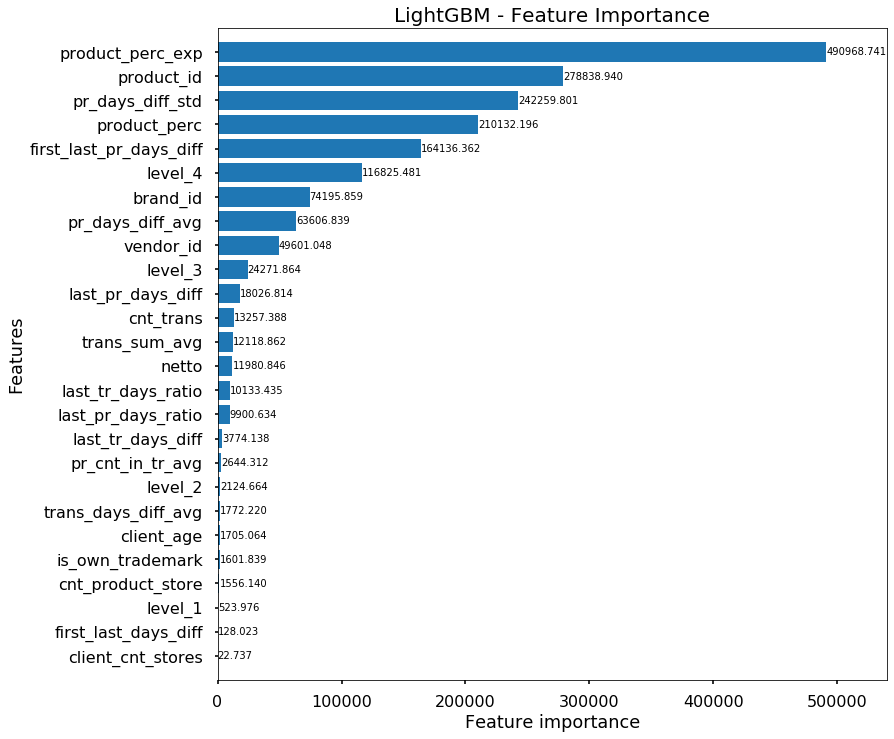

In [9]:
plot_lgb_feature_importance(lgb_model, 30)

In [10]:
items_score = [(feat,score) for feat, score 
 in zip(lgb_model.feature_name(), lgb_model.feature_importance(importance_type='gain'))]
sorted(items_score, key=lambda x: x[1], reverse=True)

[('product_perc_exp', 490968.7410621643),
 ('product_id', 278838.9402294159),
 ('pr_days_diff_std', 242259.80144500732),
 ('product_perc', 210132.19580841064),
 ('first_last_pr_days_diff', 164136.36238861084),
 ('level_4', 116825.48106384277),
 ('brand_id', 74195.8586139679),
 ('pr_days_diff_avg', 63606.83917617798),
 ('vendor_id', 49601.04771614075),
 ('level_3', 24271.863777160645),
 ('last_pr_days_diff', 18026.81357574463),
 ('cnt_trans', 13257.387672424316),
 ('trans_sum_avg', 12118.862449645996),
 ('netto', 11980.845922470093),
 ('last_tr_days_ratio', 10133.43458366394),
 ('last_pr_days_ratio', 9900.634107589722),
 ('last_tr_days_diff', 3774.138219833374),
 ('pr_cnt_in_tr_avg', 2644.3116149902344),
 ('level_2', 2124.663885116577),
 ('trans_days_diff_avg', 1772.2201175689697),
 ('client_age', 1705.0639095306396),
 ('is_own_trademark', 1601.8386001586914),
 ('cnt_product_store', 1556.1400146484375),
 ('level_1', 523.9762878417969),
 ('first_last_days_diff', 128.02260208129883),
 ('c